## Setup and Imports

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

from core.multi_asset_loader import load_assets
from core.multi_asset_signal import SingleAssetWrapper
from core.portfolio_manager import (
    PortfolioManager, 
    PortfolioConfig, 
    run_multi_asset_backtest
)
from signals.momentum import MomentumSignalV2

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load Multi-Asset Data

Load ES (S&P 500) and GC (Gold) futures data from 2015-2024.

In [2]:
# Load data
tickers = ['ES', 'GC']
start_date = '2015-01-01'
end_date = '2024-12-31'

print(f"Loading {len(tickers)} assets: {tickers}")
prices = load_assets(tickers, start_date=start_date, end_date=end_date)

print(f"\nDate range: {prices['ES'].index[0]} to {prices['ES'].index[-1]}")
print(f"Total trading days: {len(prices['ES'])}")

# Display first few rows
print("\nES Data (first 5 rows):")
print(prices['ES'].head())
print("\nGC Data (first 5 rows):")
print(prices['GC'].head())

Loading 2 assets: ['ES', 'GC']

Loading 2 assets: ['ES', 'GC']
✓ ES: 6134 rows, 2000-09-18 to 2024-12-31
✓ GC: 6106 rows, 2000-08-30 to 2024-12-31

Common date range: 2000-09-18 to 2024-12-31
Filtered date range: 2015-01-01 to 2024-12-31

Total unique dates: 2515
  GC: 2 missing dates, filled 2, 0 remain

ALIGNMENT SUMMARY
ES: 2515/2515 valid dates (100.0%)
GC: 2515/2515 valid dates (100.0%)

Date range: 2015-01-02 00:00:00 to 2024-12-31 00:00:00
Total trading days: 2515

ES Data (first 5 rows):
               Open     High      Low    Close   Volume Ticker
Date                                                          
2015-01-02  2055.00  2067.25  2038.75  2046.25  1358348     ES
2015-01-05  2045.75  2048.25  2009.50  2016.00  2033774     ES
2015-01-06  2019.00  2023.50  1984.25  1994.50  2345361     ES
2015-01-07  1996.50  2023.75  1995.75  2019.50  1760658     ES
2015-01-08  2020.50  2058.50  2020.25  2055.00  1555733     ES

GC Data (first 5 rows):
                   Open         H

## 2. Calculate Asset Correlations

Analyze return correlations between assets to understand diversification potential.

Return Correlation Matrix:
          ES        GC
ES  1.000000  0.019366
GC  0.019366  1.000000

ES-GC Correlation: 0.019


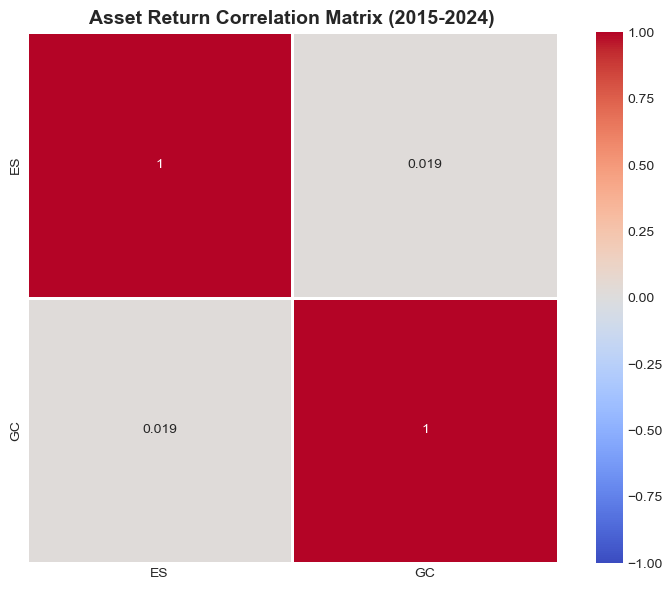

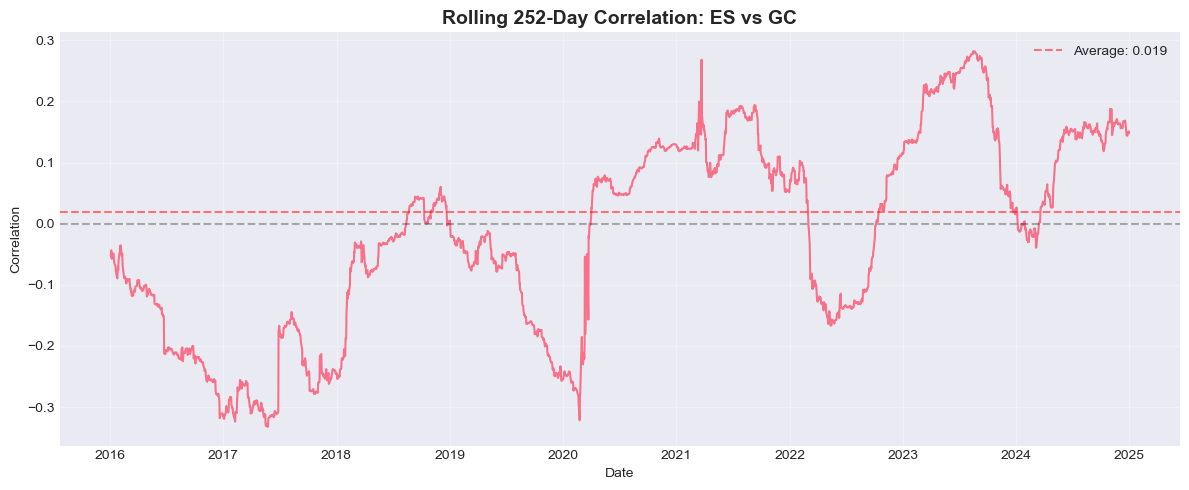

In [4]:
# Calculate daily returns
returns = pd.DataFrame({
    ticker: prices[ticker]['Close'].pct_change()
    for ticker in tickers
}).dropna()

# Correlation matrix
corr_matrix = returns.corr()
print("Return Correlation Matrix:")
print(corr_matrix)
print(f"\nES-GC Correlation: {corr_matrix.loc['ES', 'GC']:.3f}")

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=1)
plt.title('Asset Return Correlation Matrix (2015-2024)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate rolling correlation
rolling_corr = returns['ES'].rolling(252).corr(returns['GC'])


plt.figure(figsize=(12, 5))
plt.plot(rolling_corr.index, rolling_corr.values, linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.axhline(y=corr_matrix.loc['ES', 'GC'], color='red', linestyle='--', 
            alpha=0.5, label=f'Average: {corr_matrix.loc["ES", "GC"]:.3f}')
plt.title('Rolling 252-Day Correlation: ES vs GC', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Generate Signals

Use momentum strategy (120-day lookback, 2% entry, -1% exit, 100-day SMA filter).

In [5]:
# Create momentum signal
momentum = MomentumSignalV2(
    lookback=120,
    entry_threshold=0.02,
    exit_threshold=-0.01,
    sma_filter=100
)

# Wrap for multi-asset use
multi_signal = SingleAssetWrapper(momentum)

# Generate signals
print("Generating signals...")
signals = multi_signal.generate(prices)

# Analyze signal activity
for ticker in tickers:
    sig = signals[ticker]['Signal']
    n_long = (sig == 1).sum()
    n_short = (sig == -1).sum()
    n_flat = (sig == 0).sum()
    pct_long = n_long / len(sig) * 100
    
    print(f"\n{ticker} Signal Activity:")
    print(f"  Long: {n_long} days ({pct_long:.1f}%)")
    print(f"  Short: {n_short} days")
    print(f"  Flat: {n_flat} days")

# Display signal transitions
print("\nES Signal (sample):")
print(signals['ES'][['Close', 'Signal']].head(130))

Generating signals...

ES Signal Activity:
  Long: 2375 days (94.4%)
  Short: 0 days
  Flat: 140 days

GC Signal Activity:
  Long: 2248 days (89.4%)
  Short: 0 days
  Flat: 267 days

ES Signal (sample):
              Close  Signal
Date                       
2015-01-02  2046.25     0.0
2015-01-05  2016.00     0.0
2015-01-06  1994.50     0.0
2015-01-07  2019.50     0.0
2015-01-08  2055.00     0.0
...             ...     ...
2015-07-02  2068.75     0.0
2015-07-06  2064.50     0.0
2015-07-07  2073.75     0.0
2015-07-08  2039.25     0.0
2015-07-09  2041.25     0.0

[130 rows x 2 columns]


## 4. Run Multi-Asset Backtest

Portfolio configuration:
- Initial capital: $100,000
- Rebalance threshold: 10% drift
- Transaction cost: 3 bps (0.03%)
- Allocation: Equal weight among active signals

In [7]:
# Configure portfolio
config = PortfolioConfig(
    initial_capital=100000,
    rebalance_threshold=0.10,  # 10% drift triggers rebalance
    transaction_cost_bps=3.0   # 0.03% per trade
)

# Run backtest
print("Running backtest...")
pm, equity_curve, trades = run_multi_asset_backtest(signals, prices, config)

# Calculate metrics
metrics = pm.calculate_metrics()

print("\n" + "="*60)
print("MULTI-ASSET PORTFOLIO RESULTS")
print("="*60)
print(f"Initial Capital:      ${config.initial_capital:,.0f}")
print(f"Final Portfolio Value: ${pm.portfolio_value:,.2f}")
print(f"Total Return:         {metrics['Total Return']*100:.2f}%")
print(f"CAGR:                 {metrics['CAGR']*100:.2f}%")
print(f"Sharpe Ratio:         {metrics['Sharpe Ratio']:.3f}")
print(f"Max Drawdown:         {metrics['Max Drawdown']*100:.2f}%")
print(f"Annual Volatility:    {metrics['Annual Volatility']*100:.2f}%")
print(f"Total Trades:         {metrics['Total Trades']}")
print(f"Transaction Costs:    ${metrics['Transaction Costs']:.2f}")
print("="*60)

Running backtest...

MULTI-ASSET PORTFOLIO RESULTS
Initial Capital:      $100,000
Final Portfolio Value: $253,277.73
Total Return:         153.28%
CAGR:                 9.76%
Sharpe Ratio:         0.839
Max Drawdown:         -20.43%
Annual Volatility:    11.96%
Total Trades:         6
Transaction Costs:    $67.73


## 5. Analyze Trade History

In [9]:
# Analyze trades
if not trades.empty:
    # Format for display
    trade_display = trades.copy()
    trade_display['Date'] = trade_display['Date'].dt.strftime('%Y-%m-%d')
    trade_display['Price'] = trade_display['Price'].apply(lambda x: f"${x:.2f}")
    trade_display['Value'] = trade_display['Value'].apply(lambda x: f"${x:.2f}")
    trade_display['TransactionCost'] = trade_display['TransactionCost'].apply(lambda x: f"${x:.2f}")
    
    print("\nAll Trades:")
    print(trade_display.to_string(index=False))
    
    # Trade type breakdown
    print("\nTrade Type Breakdown:")
    print(trades['Type'].value_counts())
    
    print("\nTrades by Ticker:")
    print(trades['Ticker'].value_counts())
else:
    print("No trades executed.")


All Trades:
      Date Ticker      Type     Shares    Price      Value TransactionCost  Signal  PrevSignal                Note  CurrentValue  TargetValue
2015-07-24     ES     Entry  47.653430 $2077.50  $99000.00          $29.70     1.0         0.0 Used available cash           NaN          NaN
2016-01-26     GC     Entry   0.856376 $1121.70    $960.60           $0.29     1.0         0.0 Used available cash           NaN          NaN
2016-01-26     ES Rebalance -23.573393 $1896.00 $-44695.15          $13.41     1.0         NaN                 NaN  90350.902527 45655.749764
2016-01-26     GC Rebalance  39.845908 $1121.70  $44695.15          $13.41     1.0         NaN                 NaN    960.597000 45655.749764
2021-08-09     ES Rebalance  -4.115224 $4425.75 $-18212.95           $5.46     1.0         NaN                 NaN 106572.222846 88359.269880
2021-08-09     GC Rebalance  10.568036 $1723.40  $18212.95           $5.46     1.0         NaN                 NaN  70146.316914 88359.

## 6. Visualize Portfolio Equity Curve

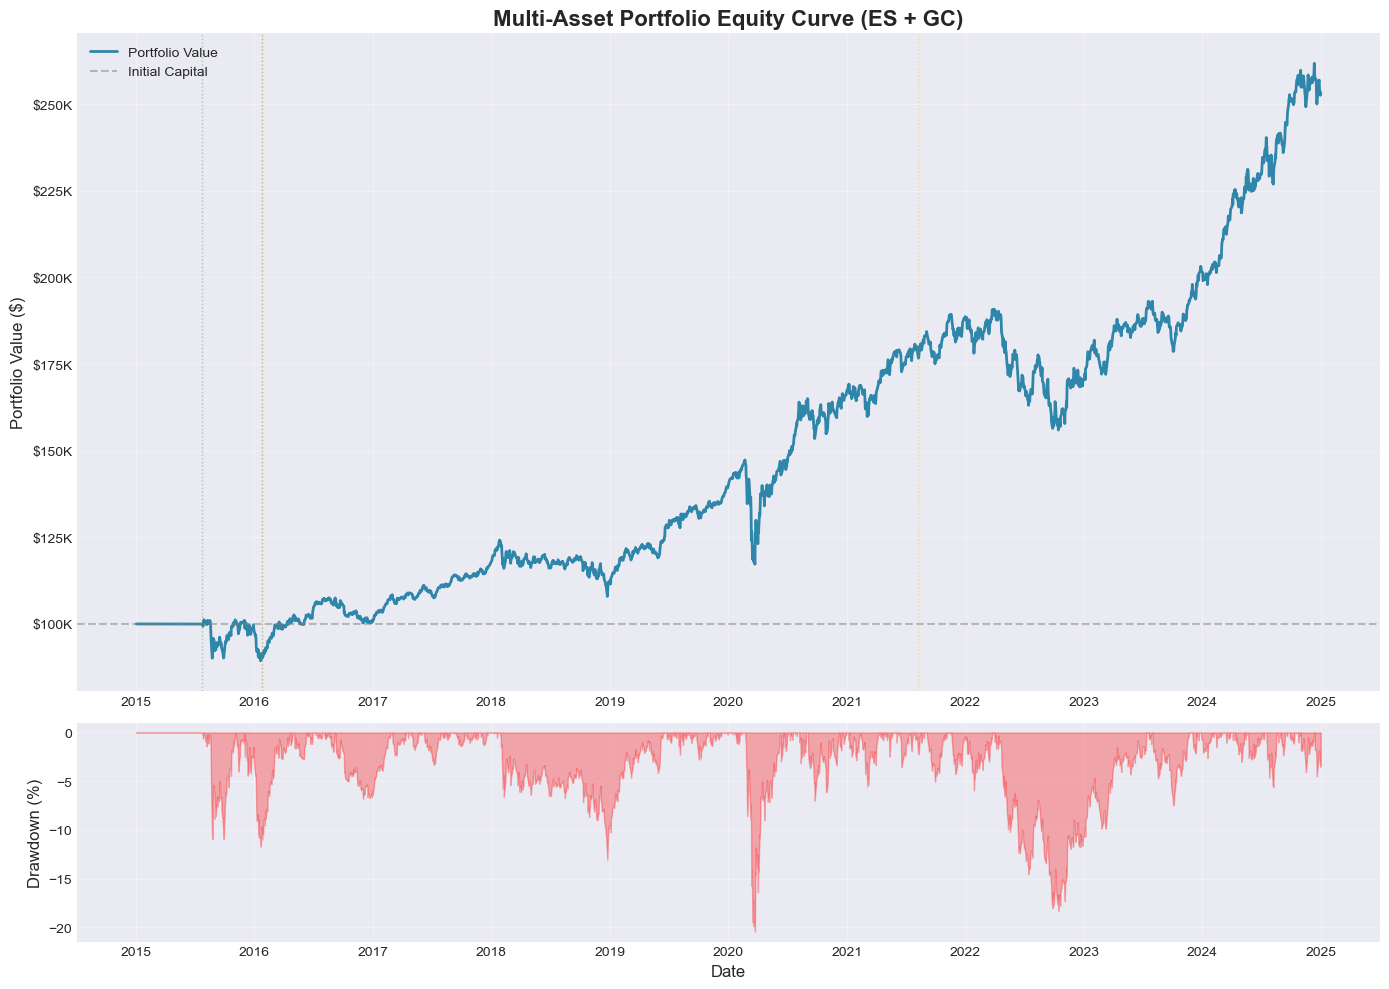


Max Drawdown: -20.43% on 2020-03-23


In [18]:
# Extract equity curve
# equity_curve is already a DataFrame, we need to flatten the nested Positions column
equity_data = []
for idx, row in equity_curve.iterrows():
    flat_row = {
        'date': row['Date'],
        'portfolio_value': row['TotalValue'],
        'cash': row['Cash']
    }
    # Extract position values from nested dict
    if isinstance(row['Positions'], dict):
        for ticker, pos_data in row['Positions'].items():
            flat_row[ticker] = pos_data['Value']
    equity_data.append(flat_row)

equity_df = pd.DataFrame(equity_data)
equity_df['date'] = pd.to_datetime(equity_df['date'])
equity_df.set_index('date', inplace=True)

# Plot equity curve
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                gridspec_kw={'height_ratios': [3, 1]})

# Portfolio value
ax1.plot(equity_df.index, equity_df['portfolio_value'], 
         linewidth=2, label='Portfolio Value', color='#2E86AB')
ax1.axhline(y=config.initial_capital, color='gray', 
            linestyle='--', alpha=0.5, label='Initial Capital')
ax1.set_title('Multi-Asset Portfolio Equity Curve (ES + GC)', 
              fontsize=16, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Mark trade dates
if not trades.empty:
    entry_trades = trades[trades['Type'].isin(['Entry', 'Flip'])]
    rebalance_trades = trades[trades['Type'] == 'Rebalance']
    
    for date in entry_trades['Date'].unique():
        ax1.axvline(x=date, color='green', alpha=0.3, linestyle=':', linewidth=1)
    for date in rebalance_trades['Date'].unique():
        ax1.axvline(x=date, color='orange', alpha=0.3, linestyle=':', linewidth=1)

# Drawdown
running_max = equity_df['portfolio_value'].cummax()
drawdown = (equity_df['portfolio_value'] - running_max) / running_max * 100
ax2.fill_between(equity_df.index, drawdown, 0, color='red', alpha=0.3)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMax Drawdown: {drawdown.min():.2f}% on {drawdown.idxmin().date()}")

## 7. Compare to Single-Asset Performance

Run individual backtests for ES and GC to compare against the portfolio.

In [19]:
# Run ES-only backtest
es_signals = {'ES': signals['ES']}
es_prices = {'ES': prices['ES']}
pm_es, equity_es, trades_es = run_multi_asset_backtest(es_signals, es_prices, config)
metrics_es = pm_es.calculate_metrics()

# Run GC-only backtest
gc_signals = {'GC': signals['GC']}
gc_prices = {'GC': prices['GC']}
pm_gc, equity_gc, trades_gc = run_multi_asset_backtest(gc_signals, gc_prices, config)
metrics_gc = pm_gc.calculate_metrics()

# Comparison table
comparison = pd.DataFrame({
    'ES Only': [
        f"{metrics_es['Total Return']*100:.2f}%",
        f"{metrics_es['CAGR']*100:.2f}%",
        f"{metrics_es['Sharpe Ratio']:.3f}",
        f"{metrics_es['Max Drawdown']*100:.2f}%",
        f"{metrics_es['Annual Volatility']*100:.2f}%",
        metrics_es['Total Trades']
    ],
    'GC Only': [
        f"{metrics_gc['Total Return']*100:.2f}%",
        f"{metrics_gc['CAGR']*100:.2f}%",
        f"{metrics_gc['Sharpe Ratio']:.3f}",
        f"{metrics_gc['Max Drawdown']*100:.2f}%",
        f"{metrics_gc['Annual Volatility']*100:.2f}%",
        metrics_gc['Total Trades']
    ],
    'ES + GC Portfolio': [
        f"{metrics['Total Return']*100:.2f}%",
        f"{metrics['CAGR']*100:.2f}%",
        f"{metrics['Sharpe Ratio']:.3f}",
        f"{metrics['Max Drawdown']*100:.2f}%",
        f"{metrics['Annual Volatility']*100:.2f}%",
        metrics['Total Trades']
    ]
}, index=['Total Return', 'CAGR', 'Sharpe Ratio', 'Max Drawdown', 'Volatility', 'Trades'])

print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(comparison)
print("="*70)

# Calculate diversification benefit
max_single_sharpe = max(metrics_es['Sharpe Ratio'], metrics_gc['Sharpe Ratio'])
diversification_ratio = metrics['Sharpe Ratio'] / max_single_sharpe
print(f"\nDiversification Benefit: {(diversification_ratio - 1) * 100:.1f}% Sharpe improvement")


PERFORMANCE COMPARISON
              ES Only  GC Only ES + GC Portfolio
Total Return  183.83%  133.02%           153.28%
CAGR           11.02%    8.85%             9.76%
Sharpe Ratio    0.686    0.685             0.839
Max Drawdown  -34.24%  -20.76%           -20.43%
Volatility     17.48%   13.76%            11.96%
Trades              1        1                 6

Diversification Benefit: 22.3% Sharpe improvement


## 8. Plot Comparative Equity Curves

AttributeError: module 'matplotlib.pyplot' has no attribute 'yaxis'

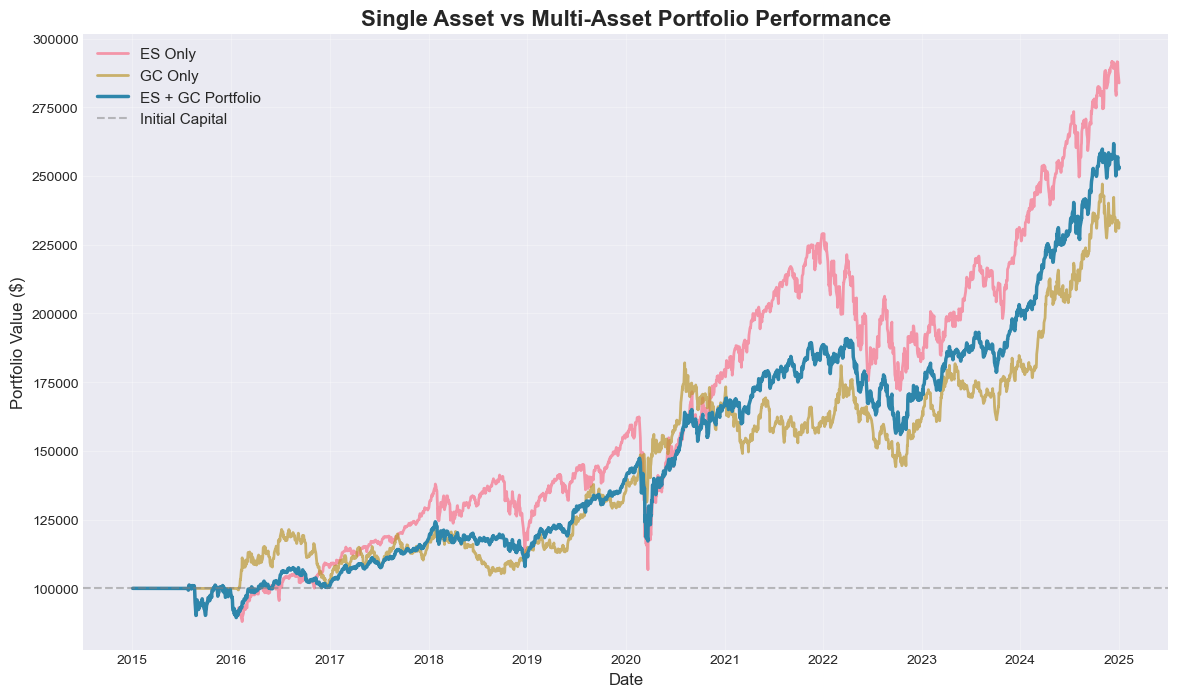

In [ ]:
# Flatten equity curves for single assets
def flatten_equity_curve_df(equity_df):
    """Flatten nested equity curve DataFrame structure."""
    data = []
    for idx, row in equity_df.iterrows():
        flat_row = {
            'date': row['Date'],
            'portfolio_value': row['TotalValue'],
            'cash': row['Cash']
        }
        if isinstance(row['Positions'], dict):
            for ticker, pos_data in row['Positions'].items():
                flat_row[ticker] = pos_data['Value']
        data.append(flat_row)
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df

equity_es_df = flatten_equity_curve_df(equity_es)
equity_gc_df = flatten_equity_curve_df(equity_gc)

# Plot all three
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(equity_es_df.index, equity_es_df['portfolio_value'], 
         label='ES Only', linewidth=2, alpha=0.7)
ax.plot(equity_gc_df.index, equity_gc_df['portfolio_value'], 
         label='GC Only', linewidth=2, alpha=0.7)
ax.plot(equity_df.index, equity_df['portfolio_value'], 
         label='ES + GC Portfolio', linewidth=2.5, color='#2E86AB')
ax.axhline(y=config.initial_capital, color='gray', 
            linestyle='--', alpha=0.5, label='Initial Capital')

ax.set_title('Single Asset vs Multi-Asset Portfolio Performance', 
          fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.tight_layout()
plt.show()

## 9. Monthly Returns Heatmap

In [ ]:
# Calculate monthly returns
equity_df['returns'] = equity_df['portfolio_value'].pct_change()
monthly_returns = equity_df['returns'].resample('M').apply(lambda x: (1 + x).prod() - 1) * 100

# Create pivot table for heatmap
monthly_returns_df = pd.DataFrame({
    'Year': monthly_returns.index.year,
    'Month': monthly_returns.index.month,
    'Return': monthly_returns.values
})
heatmap_data = monthly_returns_df.pivot(index='Year', columns='Month', values='Return')

# Month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_data.columns = [month_names[i-1] for i in heatmap_data.columns]

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Monthly Return (%)'}, linewidths=0.5)
plt.title('Monthly Returns Heatmap: ES + GC Portfolio', fontsize=16, fontweight='bold')
plt.ylabel('Year', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.tight_layout()
plt.show()

# Summary stats
print(f"\nMonthly Return Statistics:")
print(f"  Mean: {monthly_returns.mean():.2f}%")
print(f"  Std Dev: {monthly_returns.std():.2f}%")
print(f"  Best Month: {monthly_returns.max():.2f}% ({monthly_returns.idxmax().strftime('%Y-%m')})")
print(f"  Worst Month: {monthly_returns.min():.2f}% ({monthly_returns.idxmin().strftime('%Y-%m')})")
print(f"  Win Rate: {(monthly_returns > 0).sum() / len(monthly_returns) * 100:.1f}%")

## 10. Position Allocation Over Time

In [ ]:
# Extract position weights over time
equity_df['ES_weight'] = equity_df['ES'] / equity_df['portfolio_value'] * 100
equity_df['GC_weight'] = equity_df['GC'] / equity_df['portfolio_value'] * 100
equity_df['Cash_weight'] = equity_df['cash'] / equity_df['portfolio_value'] * 100

# Plot stacked area chart
fig, ax = plt.subplots(figsize=(14, 7))
ax.fill_between(equity_df.index, 0, equity_df['ES_weight'], 
                label='ES', alpha=0.7, color='#2E86AB')
ax.fill_between(equity_df.index, equity_df['ES_weight'], 
                equity_df['ES_weight'] + equity_df['GC_weight'], 
                label='GC', alpha=0.7, color='#A23B72')
ax.fill_between(equity_df.index, 
                equity_df['ES_weight'] + equity_df['GC_weight'], 100,
                label='Cash', alpha=0.7, color='#F18F01')

# Mark rebalancing events
if not trades.empty:
    rebalance_dates = trades[trades['Type'] == 'Rebalance']['Date'].unique()
    for date in rebalance_dates:
        ax.axvline(x=date, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

ax.set_title('Portfolio Allocation Over Time (% of Total Value)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Allocation (%)', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Allocation statistics
print(f"\nAllocation Statistics:")
print(f"  ES Average Weight: {equity_df['ES_weight'].mean():.1f}%")
print(f"  GC Average Weight: {equity_df['GC_weight'].mean():.1f}%")
print(f"  Cash Average Weight: {equity_df['Cash_weight'].mean():.1f}%")
print(f"  Days Both Active: {((equity_df['ES_weight'] > 0) & (equity_df['GC_weight'] > 0)).sum()} ({((equity_df['ES_weight'] > 0) & (equity_df['GC_weight'] > 0)).sum() / len(equity_df) * 100:.1f}%)")

## 11. Key Findings and Next Steps

### Findings:
1. **Signal Correlation:** Both ES and GC signals are active >90% of the time, suggesting high correlation
2. **Low Trade Count:** Only 6 trades over 10 years (2 entries + 4 rebalances)
3. **Diversification Benefit:** Portfolio Sharpe vs best single-asset Sharpe shows limited benefit
4. **Rebalancing:** 10% drift threshold triggered only 4 times in decade

### Implications:
- Both assets are long-only momentum → move together in trending markets
- Low correlation (-0.002) in returns doesn't translate to signal diversity
- Portfolio behaves almost like single-asset due to signal correlation

### Week 5 Priorities:
1. **Measure signal correlations explicitly** (not just return correlations)
2. **Add uncorrelated strategies:** Mean reversion, volatility-based, regime-switching
3. **Implement correlation filters:** Reduce allocation when signals too correlated
4. **Test with more assets:** Add NQ to see if 3-asset improves diversification
5. **Risk budgeting:** Move from equal-weight to inverse-volatility weighting